# Inference Notebook for 3D models

## Importing all necessary classes and functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py

from juart.dl.checkpoint.manager import CheckpointManager
from juart.dl.data.inference import DatasetInference
from juart.dl.model.dc import DataConsistency
from juart.dl.model.unrollnet import ExponentialMovingAverageModel, UnrolledNet
from juart.dl.operation.modules import inference
from juart.dl.model.resnet import ResNet
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint, fourier_transform_forward, fourier_transform_adjoint
from juart.vis.interactive import InteractiveFigure3D

In [2]:
# To improve performance, manually limit the number of threads
# torch.set_num_threads(16)
# torch.set_num_interop_threads(16)

## Defining all important variables for the inference

In [3]:
# dataset options
kspace_cutoff = False
nX_cutoff, nY_cutoff, nZ_cutoff = 64, 64, 64 
i_slice = [80] # number of slice that will be reconstructed
num_spokes = 64 # number of spokes that are used for the reconstruction

# device options
device = "cuda:2" # device on which the reconstructions will run

# CheckpointManager options
directory = "model_test_complex32" # directory of the dl-qrage model
root_dir = "/home/jovyan/models" # the path to the model directory
backend = "local" # the backend of the model directory

# model options
nX, nY, nZ, nTI, nTE = (156, 156, 156, 2, 1) # number of pixels in every direction // number of measurements at T1/T2 decay
shape = (nX, nY, nZ, nTI, nTE) # ordered structure of the parameters above that will be passed to the model
features = 32 # number of hidden_inputs of the dl-qrage model
cg_iter = 5 # number of cg iterations in the dl-qrage model reconstruction

# display options
vmax = 2 # sets the brightness normalization of the display between 0 and vmax
iTI, iTE = 1, 0 # sets the number of measurement that should be displayed

dtype = torch.complex32

## Loading the dataset that should be reconstructed
#### Loading Data

In [4]:
data_path = "3DLiss_vd_preproc.h5"
with h5py.File(data_path, "r") as f:
    print(f"Dataset holds following data: {f.keys()}")

    print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
    print(f"Trajectory info: {f['k'].attrs['info']}")
    print(f"Signal info: {f['d'].attrs['info']}")

    shape = (156,156,156,2,1)
    ktraj = torch.from_numpy(f['k'][:])
    coilsens = torch.from_numpy(f['coilsens'][:])
    d = torch.from_numpy(f['d'][:])

    print(f"Coilsensitivity shape {coilsens.shape}")
    print(f"Trajectory shape {ktraj.shape}")
    print(f"Signal shape {d.shape}")

Dataset holds following data: <KeysViewHDF5 ['coilsens', 'd', 'k']>
Coilsensitivity info: Shape (Channels, Nx, Ny, Nz).
Trajectory info: Shape (Dimensions, Samples, Echotimes). Scaled in units of cycle/fov
Signal info: Shape (Channels, Samples, Echotimes).
Coilsensitivity shape torch.Size([8, 156, 156, 156])
Trajectory shape torch.Size([3, 2001191, 2])
Signal shape torch.Size([8, 2001191, 2])


#### Shaping data

In [5]:
if kspace_cutoff == True:
    nX, nY ,nZ = nX_cutoff, nY_cutoff, nZ_cutoff
    shape = (nX, nY, nZ, nTI, nTE)
    
    mask = torch.linalg.norm(ktraj,dim=0) <= nX_cutoff//2
    
    ktraj = torch.stack(
        [ktraj[:, mask[:, echo], echo] for echo in range(ktraj.shape[2])],
        dim=-1
    )
    
    d = torch.stack(
        [d[:, mask[:, echo], echo] for echo in range(d.shape[2])],
        dim=-1
    )

    coilsens_ksp = fourier_transform_forward(coilsens, axes=(1,2,3))
    low_lim, up_lim = int(156/2 - nX/2), int(156/2 + nX/2)
    coilsens_ksp = coilsens_ksp[:, low_lim:up_lim, low_lim:up_lim, low_lim:up_lim]
    coilsens = fourier_transform_adjoint(coilsens_ksp, axes=(1,2,3))

In [6]:
kspace_mask_source = torch.randint(0,2,(1, ktraj.shape[1], 2,1))
kspace_mask_target = 1 - kspace_mask_source

k_scaled = ktraj / (2*ktraj.max())

AHd = nonuniform_fourier_transform_adjoint(k_scaled,d,(nX,nY,nZ))
AHd = torch.sum(torch.conj(coilsens[...,None]) * AHd, dim=0)

AHd_unsqueeze = AHd.unsqueeze(-1)
k = k_scaled.unsqueeze(-1)
d_unsqueeze = d.unsqueeze(-1)

In [7]:
data = {"images_regridded" : AHd_unsqueeze,
        "kspace_trajectory" : k,
        "sensitivity_maps" : coilsens,
        "kspace_mask_source" : kspace_mask_source,
        "kspace_mask_target" : kspace_mask_target,
        "kspace_data" : d_unsqueeze}

## Checkpoint Manager
#### Initializing the CheckpointManager and loading the current state

In [8]:
checkpoint_manager = CheckpointManager(
    directory = directory,
    root_dir = root_dir,
    backend= backend,
)

checkpoint = checkpoint_manager.load(
    ["averaged_model_state", "iteration"], map_location="cuda:3"
)

## Model
#### Initializing the model and using the CheckpointManager to check for save files of the model and load them.

In [9]:
model = UnrolledNet(
    shape,
    features=features,
    CG_Iter=cg_iter,
    num_unroll_blocks=10,
    spectral_normalization=False,
    activation="ReLU",
    kernel_size = (3,3,3),
    axes = (1,2,3),
    disable_progress_bar=False,
    ResNetCheckpoints = True,
    ConvLayerCheckpoints = False,
    device=device,
    dtype = dtype
)

model = ExponentialMovingAverageModel(model, 0.9)
model.load_state_dict(checkpoint["averaged_model_state"])

iteration = checkpoint["iteration"]
print(f"Loaded averaged at iteration {iteration}.")

/opt/conda/lib/python3.13/site-packages/torch/nn/modules/conv.py:166: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /pytorch/aten/src/ATen/EmptyTensor.cpp:56.)
  torch.empty(


Loaded averaged at iteration 1.


## Image reconstruction

In [10]:
images = inference(data, model, device=device)

100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


### Displaying the reconstructed image in an interactive Figure

interactive(children=(IntSlider(value=78, description='Dimension 3', max=156, min=1), Output()), _dom_classes=…

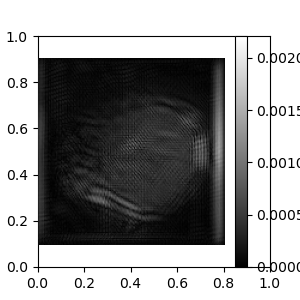

In [11]:
InteractiveFigure3D(
    torch.abs(images[...,0,0]).cpu().numpy(),
    vmin=0,
    vmax=torch.abs(images[...,0,0]).cpu().max(),
    cmap="gray",
).interactive